In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-ancient-texts-provenance-challenge/sample_submission.csv
/kaggle/input/the-ancient-texts-provenance-challenge/train.csv
/kaggle/input/the-ancient-texts-provenance-challenge/test.csv


In [3]:
pip install -U transformers huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 91.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

# Loading the dataset

In [7]:
train_df = pd.read_csv("/kaggle/input/the-ancient-texts-provenance-challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/the-ancient-texts-provenance-challenge/test.csv")

# Data Analysis

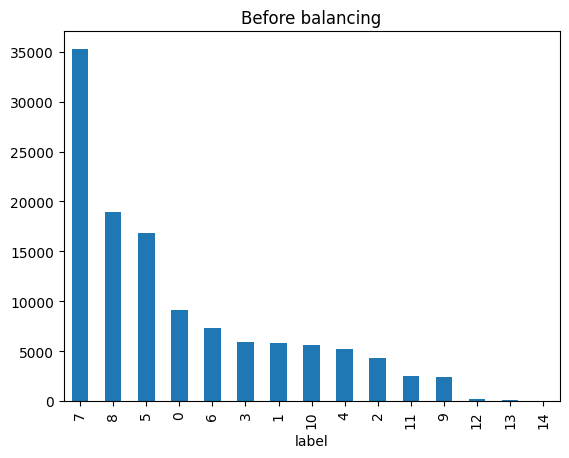

In [8]:
import matplotlib.pyplot as plt

train_df['label'].value_counts().plot(kind='bar', title='Before balancing')
plt.show()

# Weight balancing

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# compute weights from the original (unbalanced) data
classes = np.unique(train_df['label'])
weights = compute_class_weight('balanced', classes=classes, y=train_df['label'])
class_weights = torch.tensor(weights, dtype=torch.float)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
print(dict(zip(classes, weights)))

{np.int64(0): np.float64(0.8762155828939661), np.int64(1): np.float64(1.366170006279614), np.int64(2): np.float64(1.8486828891463887), np.int64(3): np.float64(1.3424884999439022), np.int64(4): np.float64(1.5387860082304528), np.int64(5): np.float64(0.4728271392725189), np.int64(6): np.float64(1.0931981179480152), np.int64(7): np.float64(0.22608810664248127), np.int64(8): np.float64(0.4220446889935277), np.int64(9): np.float64(3.288156086837043), np.int64(10): np.float64(1.4136215960777365), np.int64(11): np.float64(3.1430522721302863), np.int64(12): np.float64(47.20157790927022), np.int64(13): np.float64(56.17652582159624), np.int64(14): np.float64(3988.5333333333333)}


# Tokenization

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [9]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/119656 [00:00<?, ? examples/s]

Map:   0%|          | 0/29914 [00:00<?, ? examples/s]

# Training a Text Classifier

In [10]:
from transformers import AutoModelForSequenceClassification

num_labels = train_df['label'].nunique()

model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

2025-10-19 13:42:33.899156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760881354.109347      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760881354.181364      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import numpy as np
from sklearn.metrics import f1_score
from torch.nn import CrossEntropyLoss
from transformers import TrainingArguments, Trainer

def compute_metrics(pred):
    labels=pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    return {"f1":f1}

class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.get("label")
    outputs = model(**inputs)
    logits = outputs.get("logits")

    # apply class weights
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss


In [12]:
batch_size = 32
model_name = "distilbert-base-uncased-finetuned"
eval_size = int(0.2 * len(train_ds))
eval_dataset = train_ds.shuffle(seed=42).select(range(eval_size))


training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_strategy="epoch",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    log_level="error",
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipykernel_37/906352510.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

GPU available: True
Device: Tesla T4


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,1.684500,1.379727,0.357194
2,1.366300,1.230746,0.412175


TrainOutput(global_step=7480, training_loss=1.5254119057068851, metrics={'train_runtime': 11581.3405, 'train_samples_per_second': 20.664, 'train_steps_per_second': 0.646, 'total_flos': 3.170838756630528e+16, 'train_loss': 1.5254119057068851, 'epoch': 2.0})

# Prediction

In [ ]:
preds = trainer.predict(test_ds)
test_preds = np.argmax(preds.predictions, axis=1)

In [ ]:
print(len(test_preds))

In [ ]:
ids = test_ds["id"]

df = pd.DataFrame({
    "id": ids,
    "label": test_preds
})

print(df.head())

       id  label
0  114610      5
1    1146      8
2   39252      2
3   56935      7
4  113433      8


In [ ]:
df.to_csv("submission.csv", index=False)